# Read Noise Distributions

<br>Owner: **Emily Phillips Longley** and **Keith Bechtol**
<br>Last Verified to Run: **2018-11-14**
<br>Verified Stack Release: **w_2018_45**

See examples in the eotest:
* [read_noise.py](https://github.com/lsst-camera-dh/eotest/blob/master/python/lsst/eotest/sensor/read_noise.py)
* [total_noise_histograms.py](https://github.com/lsst-camera-dh/eotest/blob/master/python/lsst/eotest/sensor/total_noise_histograms.py)

Our goal is to compute determine the noise distributions for each amplifier. The total noise has contributions from read noise, system noise, and shot noise added in quadrature.

$\sigma_{\rm total} = \sqrt{\sigma_{\rm read}^{2} + \sigma_{\rm system}^{2} + \sigma_{\rm shot}^{2}}$

**Read noise:**

**System noise:**

**Total read noise:**

**Shot noise:** Poisson noise contribution from dark current. The variance is equal to the dark current (electrons per second) multiplied by the exposure time (seconds).

Other things to check. Look at adjascent pixels. Correlations. Some will be correlated, some will be uncorrelated.

Inputs include the 
* gain per amp, 
* dark current array over pixels

In [1]:
! eups list -s | grep lsst_distrib

lsst_distrib          16.0-1-g3bbe181+31 	current w_2018_45 setup


In [2]:
%matplotlib inline
#%matplotlib notebook

# system imports
import os
import numpy as np
from matplotlib import pylab as plt

# LSST stack imports
from lsst.daf.persistence import Butler
from lsst.ip.isr import IsrTask
import lsst.afw.display as afwDisplay

# Firefly client imports
from firefly_client import FireflyClient
from IPython.display import IFrame

In [33]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False

isr_bias = IsrTask(config=isr_config)

In [34]:
isr_config = IsrTask.ConfigClass()

isr_config.doBias=False
isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False

isr_assemble = IsrTask(config=isr_config)

In [5]:
# Instantiate butler and print out what types of raw exposures exist in this data repository
BOOTCAMP_REPO_DIR = '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
butler.queryMetadata('raw', ['imageType'])

['BIAS', 'DARK', 'FE55', 'FLAT', 'fluxcalib', 'PPUMP']

## Read noise

In [6]:
# Start by identifying one bias frame
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'BIAS'})
print(visits)

[258334360, 258334672, 258334985, 258335297, 258335608, 258338033, 258338346, 258338660, 258338973, 258339284, 258339732, 258339799, 258339867, 258339937, 258340007, 258340077, 258340152, 258340195, 258340236, 258340282, 258340332, 258340383, 258340438, 258340500, 258340568, 258340646, 258340740, 258340850, 258340989, 258341162, 258341382, 258341635, 258341916, 258342229, 258342550, 258342881, 258343221, 258343573, 258343932, 258344308, 258344701, 258345114, 258345543, 258345990, 258346455, 258346938, 258347437, 258347953, 258348488, 258350158, 258350371, 258350670, 258350693, 258350717, 258350742, 258350767, 258350790, 258350815, 258350838, 258350863, 258350887, 258350911, 258350935, 258350959, 258350984, 258351008, 258351032, 258351057, 258351081, 258351105, 258351130, 258351154, 258351178, 258351202, 258351226, 258351250, 258351292, 258351436, 258351575, 258351712, 258351849, 258351986, 258352118, 258352254, 258352394, 258352528, 258353336, 258353632, 258353884, 258354053, 258354195

In [7]:
dId = dict(visit=visits[0], detector=2) # Note that detector is a required keyword
print(dId)

{'visit': 258334360, 'detector': 2}


In [8]:
raw = butler.get('raw', dId)

# Show metadata for this frame
# print(raw.getMetadata())

# Show the detector name
# raw.getDetector().getName()

In [9]:
# Get the corresponding master bias and master dark
bias = butler.get('bias', dId)
dark = butler.get('dark', dId)

In [35]:
result_assemble = isr_assemble.run(raw, bias=bias)
result_bias = isr_bias.run(raw, bias=bias)

7.576922
7.0405297
(4004, 4096)
(4004, 4096)


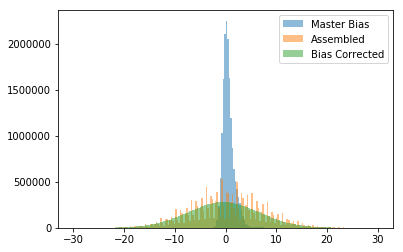

In [62]:
raw_image = raw.getMaskedImage().getImage().getArray()
assemble_corrected_image = result_assemble.exposure.getMaskedImage().getImage().getArray()
bias_corrected_image = result_bias.exposure.getMaskedImage().getImage().getArray()
master_bias_image = bias.getMaskedImage().getImage().getArray()

print(np.std(assemble_corrected_image))
print(np.std(bias_corrected_image))
print(assemble_corrected_image.shape)
print(bias_corrected_image.shape)

bins = np.linspace(-30, 30, 201)
plt.figure()
plt.hist(master_bias_image.flatten(), bins=bins, alpha=0.5, label='Master Bias')
plt.hist(assemble_corrected_image.flatten(), bins=bins, alpha=0.5, label='Assembled')
plt.hist(bias_corrected_image.flatten(), bins=bins, alpha=0.5, label='Bias Corrected')
plt.legend(loc='upper right')

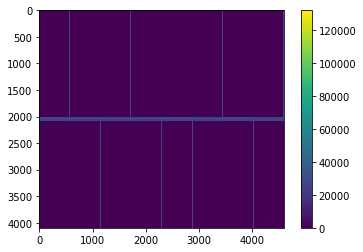

In [12]:
plt.figure()
plt.imshow(raw_image)
plt.colorbar()

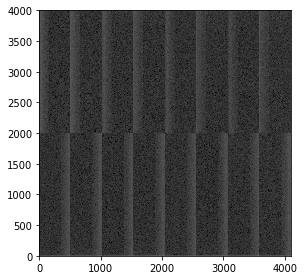

In [61]:
#afw_display = afwDisplay.getDisplay(frame=1, 
#                                    name=my_channel)
#afw_display.mtv(result.exposure)

afwDisplay.setDefaultBackend('matplotlib')
my_display = afwDisplay.Display()
my_display.scale("asinh", "zscale")
#my_display.mtv(result_assemble.exposure)
my_display.mtv(bias.getMaskedImage())

In [26]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'

ff='{}/firefly/slate.html?__wsch={}'.format(server, my_channel)
IFrame(ff,800,600)

In [27]:
afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

In [57]:
#afw_display.mtv(result_assemble.exposure)
afw_display.mtv(bias.getMaskedImage())

---

In [ ]:
butler.queryMetadata('raw', ['detector', 'detectorName'])

In [ ]:


butler.getKeys('bias')
butler.queryMetadata('bias', ['detector'])
#bias = butler.queryMetadata('bias', ['visit'])
#print(bias)

In [ ]:
dId = dict(visit=visits[0], detector=2)
raw = butler.get('raw', dId, visit=258345990)

In [ ]:
dark = butler.get('dark', dId)
dark.getMetadata().toDict()

for a in raw.getDetector():
    print(a.getName(), a.getReadNoise(), a.getGain())

In [ ]:
result = isr.run(raw, bias=bias)

## Creating master dark

---

In [ ]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay

In [ ]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

This notebook requires the package `obs_lsst`, which is not currently distributed in the LSP. If the following cell raises an exception, see the instructions in `welcome_to_FE55.ipynb`.

In [ ]:
import eups
assert eups.getSetupVersion("obs_lsst")

In [ ]:
my_channel = '{}_test_channel'.format(os.environ['USER'])
server = 'https://lsst-lspdev.ncsa.illinois.edu'


afwDisplay.setDefaultBackend('firefly')
afw_display = afwDisplay.getDisplay(frame=1, 
                                    name=my_channel)

In [ ]:
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})

In [ ]:
dId = {'visit': visits[0], 'detector': 2}
raw = butler.get('raw', **dId)

In [ ]:
detector = raw.getDetector()

In [ ]:
afw_display.mtv(raw)

In [ ]:
# for the geometry we've chosen, the y=0 amps are in the top
# Normally the read corner would tell you this, but there is currently a bug
flipXY = {'C00':(False, True),
          'C01':(False, True),
          'C02':(False, True),
          'C03':(False, True),
          'C04':(False, True),
          'C05':(False, True),
          'C06':(False, True),
          'C07':(False, True),
          'C10':(True, False),
          'C11':(True, False),
          'C12':(True, False),
          'C13':(True, False),
          'C14':(True, False),
          'C15':(True, False),
          'C16':(True, False),
          'C17':(True, False)}

In [ ]:
overscans = {}
for key, value in flipXY.items():
    bbox = detector[key].getRawHorizontalOverscanBBox()
    overscans[key] = raw[bbox].getMaskedImage().getImage().clone() # since these are views into the pixels, we want a copy so we don't mess with the pixels in the original image

In [ ]:
for channel_name, flips in flipXY.items():
    # get all the overscans in the same orientation and plot the mean along the y-axis
    arr = overscans[channel_name].getArray() # pull out numpy array
    oscan = numpy.mean(arr)
    fx, fy = flips
    if fx:
        arr = numpy.flip(arr, axis=1)
    if fy:
        arr = numpy.flip(arr, axis=0)
    # aggregate along y-axis.  It's ok to use array math here since we don't have any masks to begin with.
    mean = numpy.mean(arr, axis=0)
    plt.plot(mean-oscan, label=channel_name)

plt.xlabel('pixel index')
plt.ylabel('mean counts along parallel direction')
plt.xlim(0, 65)
plt.ylim(-0.5, 0.5)
plt.legend()